# Adam for glms

## Imports

In [1]:
import scipy
import numpy as np
from jax import jit, vmap, grad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.numpy.linalg import norm
from tqdm.notebook import tqdm
from jax.nn import sigmoid as sig

from opt_methods import one_pass_adam, risk, adam_sde_diag

def compute_confidence_interval(data, confidence=0.8):
    lower_quantile = (1 - confidence) / 2
    upper_quantile = 1 - lower_quantile
    lower = np.quantile(data, lower_quantile, axis=0)
    upper = np.quantile(data, upper_quantile, axis=0)
    return lower, upper

def distance_to_optimal(K, theta, theta_star):
    return norm(theta - theta_star)

### Logistic regression CE functions
def logreg(data, theta):
    logits = jnp.dot(data, theta)  
    probabilities = sig(logits)
    return probabilities

def student_teacher_ce(theta, data, target):
    p_student = logreg(data, theta)        
    return -(target * jnp.log(p_student) + (1 - target) * jnp.log(1 - p_student))

# Linear regression

Once we define both our gradient function and the "f" function that gives the coefficient of the gradient we can drop these into our Adam and Adam-SDE implementations. 

In [2]:
def grad_linreg(theta, data, target):    
    return (jnp.inner(data, theta) - target) * data

@jit
def f_linreg(r):
    r1 = r[:,0]
    r2 = r[:,1]
    return r1 - r2

In [3]:
## Set hyperparameters
d = 500 # dimension
lr = 0.7 # SDE learning rate
lrk = lr / d # Adam learning rate
beta1 = 0 
beta2 = 0.95

T = 3 # time to run SDE for
n = int(T * d) # number of samples from our data

params0 = jnp.ones(d)
optimal_params = jnp.linspace(0.1,2,d)

params0 /= norm(params0)
optimal_params /= norm(optimal_params)

## Define our covariance matrix (Note that for now this must be diagonal)
K = jnp.diag(jnp.linspace(0.01, 1.5, d))
Kbar = jnp.sqrt(K)

In [4]:
num_runs = 5  # Number of runs for averaging

# Storage for results
sde_vals_all_linreg = []
adam_vals_all_linreg = []

# Loop over multiple runs
for _ in tqdm(range(num_runs)):
    # Generate new data and targets for each run
    data = np.random.multivariate_normal(mean=np.zeros(d), cov=K, size=n)
    data = jnp.array(data)
    targets = data @ optimal_params  # Setup regression targets

    key = jax.random.PRNGKey(np.random.randint(0, 10000))
    
    sde_vals, sde_times = adam_sde_diag(risk, f_linreg, T, lr, K, Kbar, beta2, params0, optimal_params, d, key=key)
    adam_vals, adam_times = one_pass_adam(risk, grad_linreg, K, data, targets, params0, optimal_params, lrk, beta1, beta2)
    
    sde_vals_all_linreg.append(sde_vals)
    adam_vals_all_linreg.append(adam_vals)

# Convert results to arrays for easier manipulation
sde_vals_all_linreg = jnp.array(sde_vals_all_linreg)  # Shape: (num_runs, num_steps)
adam_vals_all_linreg = jnp.array(adam_vals_all_linreg)  # Shape: (num_runs, num_steps)

# Compute 80% confidence intervals
sde_lower_linreg, sde_upper_linreg = compute_confidence_interval(sde_vals_all_linreg)
adam_lower_linreg, adam_upper_linreg = compute_confidence_interval(adam_vals_all_linreg)

  0%|          | 0/5 [00:00<?, ?it/s]

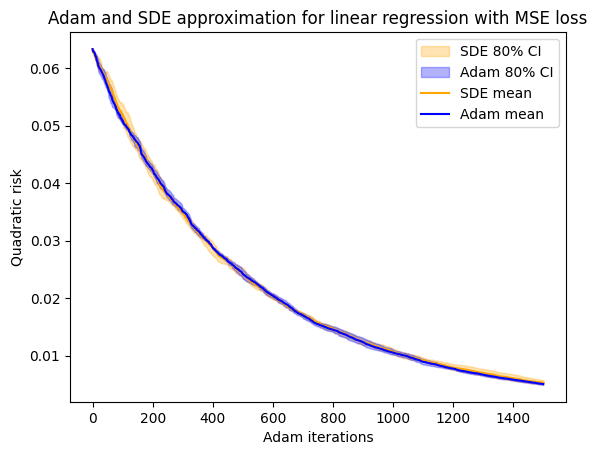

In [5]:
# Plot the results with confidence intervals
adam_color = 'blue'
sde_color = 'orange'
plt.fill_between(sde_times * d, sde_lower_linreg, sde_upper_linreg, color=sde_color, alpha=0.3, label='SDE 80% CI')
plt.fill_between(adam_times, adam_lower_linreg, adam_upper_linreg, color=adam_color, alpha=0.3, label='Adam 80% CI')

plt.plot(sde_times * d, jnp.mean(sde_vals_all_linreg, axis=0), color=sde_color, label='SDE mean')
plt.plot(adam_times, jnp.mean(adam_vals_all_linreg, axis=0), color=adam_color, label='Adam mean')

plt.title('Adam and SDE approximation for linear regression with MSE loss')
plt.xlabel('Adam iterations')
plt.ylabel('Quadratic risk')
plt.legend()
plt.show()

## Logistic regression

Like above, once we provide the gradient and gradient coefficient functions we can get some results. 

In [6]:
def grad_logreg(theta, data, target):
    p_student = logreg(data, theta)
    return (p_student - target) * data

@jit
def f_logreg(r):
    r1 = r[:,0]
    r2 = r[:,1]
    return sig(r1) - sig(r2)

In [7]:
# ## Set hyperparameters
# d = 20 # dimension
# lr = 0.7 # SDE learning rate
# lrk = lr / d # Adam learning rate
# beta1 = 0 
# beta2 = 0.4

# T = 3 # time to run SDE for
# n = int(T * d) # number of samples from our data

# params0 = jnp.ones(d)
# optimal_params = jnp.linspace(0.1,2,d)

# params0 /= norm(params0)
# optimal_params /= norm(optimal_params)

# ## Define our covariance matrix (Note that for now this must be diagonal)
# K = jnp.diag(jnp.linspace(0.01, 1.5, d))
# Kbar = jnp.sqrt(K)

In [8]:
# num_runs = 2  # Number of runs to average over

sde_vals_all_logreg = []
adam_vals_all_logreg = []
for _ in tqdm(range(num_runs)):
    # Generate new data and targets for each run
    data = np.random.multivariate_normal(mean=np.zeros(d), cov=K, size=n)
    data = jnp.array(data)
    targets = logreg(data, optimal_params)  # Setup student-teacher targets

    key = jax.random.PRNGKey(np.random.randint(0, 10000))
    
    sde_vals, sde_times = adam_sde_diag(risk, f_logreg, T, lr, K, Kbar, beta2, params0, optimal_params, d, key=key)
    adam_vals, adam_times = one_pass_adam(risk, grad_logreg, K, data, targets, params0, optimal_params, lrk, beta1, beta2)
    
    sde_vals_all_logreg.append(sde_vals)
    adam_vals_all_logreg.append(adam_vals)

sde_vals_all_logreg = jnp.array(sde_vals_all_logreg)
adam_vals_all_logreg = jnp.array(adam_vals_all_logreg)

# Compute 80% confidence intervals
sde_lower_logreg, sde_upper_logreg = compute_confidence_interval(sde_vals_all_logreg)
adam_lower_logreg, adam_upper_logreg = compute_confidence_interval(adam_vals_all_logreg)

  0%|          | 0/5 [00:00<?, ?it/s]

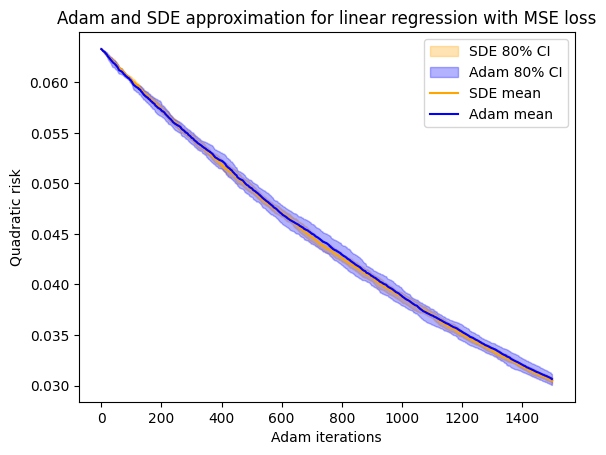

In [9]:
# Plot the results with confidence intervals
adam_color = 'blue'
sde_color = 'orange'
plt.fill_between(sde_times * d, sde_lower_logreg, sde_upper_logreg, color=sde_color, alpha=0.3, label='SDE 80% CI')
plt.fill_between(adam_times, adam_lower_logreg, adam_upper_logreg, color=adam_color, alpha=0.3, label='Adam 80% CI')

plt.plot(sde_times * d, jnp.mean(sde_vals_all_logreg, axis=0), color=sde_color, label='SDE mean')
plt.plot(adam_times, jnp.mean(adam_vals_all_logreg, axis=0), color=adam_color, label='Adam mean')

plt.title('Adam and SDE approximation for linear regression with MSE loss')
plt.xlabel('Adam iterations')
plt.ylabel('Quadratic risk')
plt.legend()
plt.show()